# Linear Error-in-Variables Mixture Model

Reproduction of examples from section 4 in the original paper; the main aim is to compare the treelet transform with PCA.The task at hand is the recovery of the unobserved structure of the mixture model from a random sample. Data from each example is saved to `/data` for use with R. 

## Setup

In [1]:
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import numpy as np 
import pandas as pd
import sys
import os

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
sys.path.append("../scripts")
import python_treelet_implementation as pytree
import test_treelets_mixture_models as model
import utils

## Model setup

The paper considers a sample $\left \{ \vec{x}_i \right \}_{i=1}^{n}$ where each multivariate observation $\vec{x} \in \mathbb{R}^p$ has the form $\vec{x} = \sum_{i=}^{K}u_j \vec{v}_j + \sigma \vec{z}$ and each component corresponds to:

* factors: $\left ( u_1, ... u_k \right )^T \sim F_{u_1,...,u_K}$
* loading vectors: $\vec{v}_j$ 
* noise: $\vec{z} \sim \mathcal{N}_p\left ( 0, I \right )$

## Uncorrelated factors and non-overlapping loading vectors 

Data is simulated according to example 1 and re-scaled to have mean 0 and variance 1. The example consists of three non-overlapping loading vectors and uncorrelated Gaussian factors. 

In [4]:
X = model.linear_mixture_model(V = np.array([[1,1,1,0,0,0,0,0,0,0],
                                            [0,0,0,1,1,1,1,0,0,0],
                                            [0,0,0,0,0,0,0,1,1,0]])\
                                    .transpose(),
                         C = 2*np.identity(3), 
                         sigma = 1, 
                         n = 1000)

In [5]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pd.DataFrame(X).to_csv("../data/3_uncorrelated_factors.csv",index = False)

Sample covaraince matrix exhibits block structure as required and expected. 

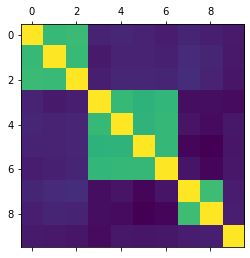

In [6]:
plt.matshow(np.cov(X.transpose()))

### PCA

Performing PCA and examining the loadings for the first three components the factor structure is apparent. However the loading sign can be misleading. By definition each loading component is non-zero for components calculated on the sample covariance matrix; this further complicates the task of recovering the factor structure. 

In [7]:
pca = PCA(n_components=3)
pca.fit(X)
loadings = pca.components_.T 
loadings

array([[-0.03435147,  0.57468905,  0.04234363],
       [-0.03396191,  0.57446807,  0.06002503],
       [-0.00209224,  0.57252302,  0.06976903],
       [-0.50216326, -0.02524546, -0.01013001],
       [-0.4950012 , -0.01764762, -0.03851435],
       [-0.50048841, -0.00394662, -0.0181509 ],
       [-0.49787156, -0.02766605, -0.01046167],
       [ 0.03578516,  0.06954949, -0.7024701 ],
       [ 0.01411998,  0.07270302, -0.70295102],
       [ 0.02496747, -0.00914842,  0.01034621]])

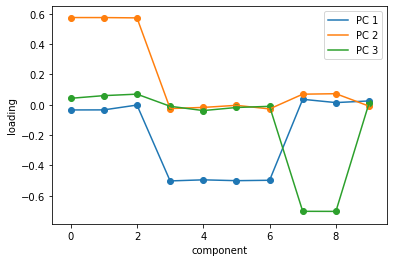

In [8]:
p,l = loadings.shape
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l])
    plt.plot(np.arange(p),loadings[:,l], label = "PC " + str(l+1))
    
plt.xlabel("component")
plt.ylabel("loading")
plt.legend()

### Treelet decomposition

Using the treelet decomposition algorithm and the best basis selection method (pp. 9) with $K=3$ the factor structure is also apparent. A major difference is that the treelet decomposition returns a sparse basis in the $l_0$ sense - loading entries for variables on which local PCA has not been performed are exactly zero - which is not the case for regular PCA. 

In [9]:
tree = pytree.treelet_decomposition(X = X,
                             L = 9)
loadings = pytree.best_basis(tree,3,X)[0]["basis"]
loadings

array([[ 0.57509022,  0.0210917 , -0.05629473],
       [ 0.57509022,  0.0210917 , -0.05629473],
       [ 0.57247999,  0.02099597, -0.05603921],
       [-0.01839189,  0.50147662,  0.        ],
       [-0.01818684,  0.49588567,  0.        ],
       [-0.01833027,  0.49979647,  0.        ],
       [-0.01839189,  0.50147662,  0.        ],
       [ 0.06879627,  0.00252314,  0.70374762],
       [ 0.06879627,  0.00252314,  0.70374762],
       [ 0.        ,  0.        ,  0.        ]])

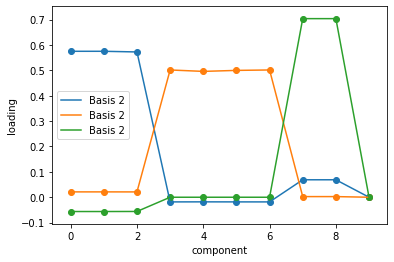

In [10]:
p,l = loadings.shape
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l])
    plt.plot(np.arange(p),loadings[:,l], label = "Basis " + str(1+1))
    
plt.xlabel("component")
plt.ylabel("loading")
plt.legend()

## Correlated factors and non-overlapping loading vectors 

Data is generated according to example 2 and re-scaled. As in the previous example the loading vectors are non-overlapping, however the factors are generated according to:
* $u_1 \sim \mathcal{N}(0, \sigma_1^2)$
* $u_2 \sim \mathcal{N}(0, \sigma_2^2)$
* $u_3 = c_1 u_1 + c_2 u_2$

In [7]:
X = model.three_correlated_factors(V = np.array([[1,1,1,1,0,0,0,0,0,0],
                                                 [0,0,0,0,1,1,1,1,0,0],
                                                 [0,0,0,0,0,0,0,0,1,1]])\
                                   .transpose(),
                                   sigma = 1, 
                                   sigma1 = np.sqrt(290), 
                                   sigma2 = np.sqrt(300),
                                   c1 = -0.3, 
                                   c2 = 0.925,
                                   n = 1000
                                  )

In [8]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pd.DataFrame(X).to_csv("../data/3_correlated_factors.csv", index = False)

The sample covariance matrix again exhibits the required block structure. This time off-diagonal entries (outside of factor blocks) are not statistical estimates of zero. 

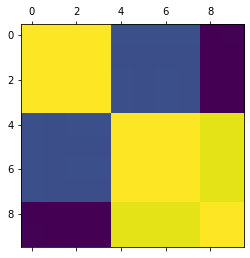

In [9]:
plt.matshow(np.cov(X, rowvar = False))

### PCA

The underlying structure of the factor model is not at all clear from the loadings plot. 

In [10]:
pca = PCA(n_components=3)
pca.fit(X)
loadings = pca.components_.T 
loadings

array([[ 0.10566767,  0.48052734, -0.18553022],
       [ 0.1070489 ,  0.48009612,  0.37647554],
       [ 0.10623354,  0.48034712,  0.2123459 ],
       [ 0.10616922,  0.48039747, -0.15646607],
       [-0.39343449,  0.13885239, -0.00793671],
       [-0.39360934,  0.13807621, -0.43927277],
       [-0.39350489,  0.13849142, -0.42246687],
       [-0.39365583,  0.13788505,  0.10724534],
       [-0.40942838, -0.0173275 ,  0.23621452],
       [-0.40945791, -0.01576958,  0.5616686 ]])

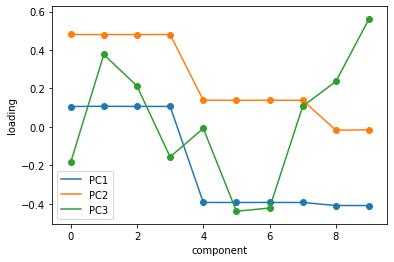

In [11]:
p,l = loadings.shape
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l])
    plt.plot(np.arange(p),loadings[:,l], label = "PC" + str(l+1))
    
plt.xlabel("component")
plt.ylabel("loading")
plt.legend()

### Treelet decomposition

The treelet decomposition is generally able to recover the factor structure with the best K basis selection method.

In [12]:
tree = pytree.treelet_decomposition(X = X, 
                                    L = 10)
best_K_bases = pytree.best_basis(tree,3,X)
loadings = best_K_bases[0]["basis"]
loadings

array([[ 0.48950091, -0.10186466,  0.        ],
       [ 0.4895236 , -0.10186938,  0.        ],
       [ 0.48950429, -0.10186536,  0.        ],
       [ 0.4895236 , -0.10186938,  0.        ],
       [ 0.0836499 ,  0.40197162, -0.28533871],
       [ 0.08365174,  0.40198049, -0.28534501],
       [ 0.08365174,  0.40198049, -0.28534501],
       [ 0.08364843,  0.40196459, -0.28533372],
       [ 0.08221346,  0.39506895,  0.58065607],
       [ 0.08221346,  0.39506895,  0.58065607]])

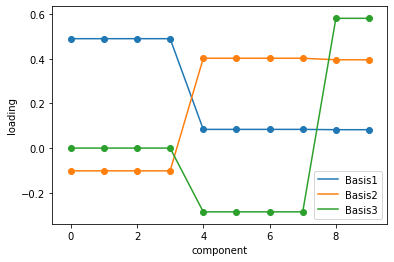

In [13]:
p,l = loadings.shape
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l])
    plt.plot(np.arange(p),loadings[:,l], label = "Basis" + str(l+1))
    
plt.xlabel("component")
plt.ylabel("loading")
plt.legend()

Without cross-validation, when the sample size is low or the between block correlation is high, the best basis selection method seems to be bised towards loading vectors calculated higher up the tree. 

In [47]:
Z = model.three_correlated_factors(V = np.array([[1,1,1,1,0,0,0,0,0,0],
                                                 [0,0,0,0,1,1,1,1,0,0],
                                                 [0,0,0,0,0,0,0,0,1,1]])\
                                   .transpose(),
                                   sigma = 1, 
                                   sigma1 = np.sqrt(2), 
                                   sigma2 = np.sqrt(3),
                                   c1 = -0.3, 
                                   c2 = 0.925,
                                   n = 1000
                                  )
tree = pytree.treelet_decomposition(X = Z, 
                                    L = 10)
best_K_bases = pytree.best_basis(tree,3,X)
loadings = best_K_bases[0]["basis"]
best_K_bases[0]

100%|██████████| 9/9 [00:00<00:00, 15.50it/s]


{'level': 9,
 'energy': 0.9925653892916085,
 'index': [0, 5, 8],
 'basis': array([[ 0.50581697, -0.03696685,  0.        ],
        [ 0.50193598, -0.03668322,  0.        ],
        [ 0.49925763, -0.03648747,  0.        ],
        [ 0.48748176, -0.03562685,  0.        ],
        [ 0.03062288,  0.41901246, -0.21471484],
        [ 0.03067951,  0.41978728, -0.21511188],
        [ 0.02977761,  0.40744665, -0.20878816],
        [ 0.03030007,  0.4145954 , -0.2124514 ],
        [ 0.02854281,  0.39055094,  0.9049289 ],
        [ 0.02853647,  0.39046412,  0.        ]])}

With knowledge of the population model we see that at the level where we would expect all variables within the same block to be merged the treelet decomposition has in fact recovered the factor structure. 

In [48]:
best_K_bases[1][7]

{'level': 7,
 'energy': 0.9855698911053201,
 'index': [0, 1, 5],
 'basis': array([[0.58691176, 0.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.5793008 , 0.        , 0.        ],
        [0.56563697, 0.        , 0.        ],
        [0.        , 0.        , 0.42012998],
        [0.        , 0.        , 0.42090687],
        [0.        , 0.        , 0.40853333],
        [0.        , 0.        , 0.41570114],
        [0.        , 0.        , 0.39159256],
        [0.        , 0.        , 0.3915055 ]])}

## Uncorrelated factors and overlapping loading vectors $(p < n)$

Data is generated according to example 3: factors are uncorrelated, and the first and second loading vectors overlap. Unlike the original example let $p<n$. Factors are generated according to the model specified in Bair et al. (2006): 
* $u_1 = \pm 0.5$ with equal probability
* $u_2 = I(U_2 < 0.4)$ with $U_2 \sim \mathcal{U}(0,1)$
* $u_3 = I(U_2 < 0.3)$ with $U_3 \sim \mathcal{U}(0,1)$

In [49]:
X = model.Bair_et_al(V = np.array([np.concatenate((np.repeat(1,20),np.repeat(0,80))),
                                   np.concatenate((np.repeat(0,10),np.repeat(1,40),np.repeat(0,50))),
                                   np.concatenate((np.repeat(0,60),np.repeat(1,40)))]).transpose(),
                         sigma = .5, 
                         n = 500)

In [50]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pd.DataFrame(X).to_csv("../data/3_overlapping_vectors_low_dim.csv", index = False)

The sample covariance matrix shows the desired block structure, with the first and second block overlapping: 

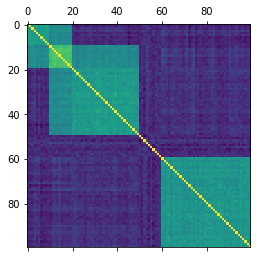

In [51]:
plt.matshow(np.cov(X, rowvar = False))

### PCA

The loadings plot is messy, but PCA is nonetheless able to recover the underlying factor structure. 

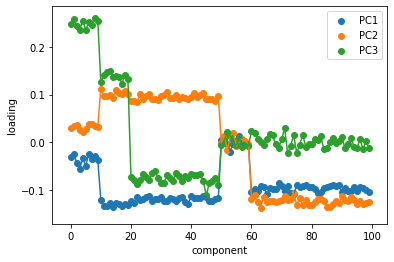

In [52]:
pca = PCA(n_components=3)
pca.fit(X)
loadings = pca.components_.T 

p,l = loadings.shape
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l], label = "PC" + str(l+1))
    plt.plot(np.arange(p),loadings[:,l])
    
plt.xlabel("component")
plt.ylabel("loading")
plt.legend()

### Treelet decomposition

Treelets are likewise able to recover the factor structure. 

In [53]:
tree = pytree.treelet_decomposition(X = X, 
                                    L = 100)
best_K_bases = pytree.best_basis(tree,3,X)
loadings = best_K_bases[0]["basis"]

100%|██████████| 99/99 [00:31<00:00,  3.13it/s]


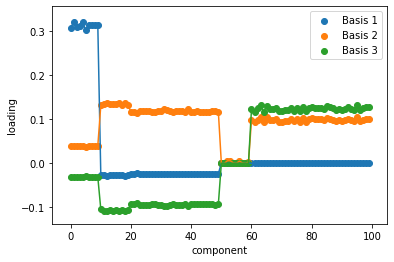

In [54]:
p,l = loadings.shape
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l], label = "Basis " + str(l+1))
    plt.plot(np.arange(p),loadings[:,l])

plt.xlabel("component")
plt.ylabel("loading")
plt.legend()

## Uncorrelated factors and overlapping loading vectors $(p \gg n)$

Similar to the above, only the problem is made to be highly dimensional by choosing $\text{dim}(\vec{x}) = p = 400$ and $n = 100$.

In [55]:
X = model.Bair_et_al(V = np.array([np.concatenate((np.repeat(1,50),np.repeat(0,350))),
                                   np.concatenate((np.repeat(0,10),np.repeat(1,90),np.repeat(0,300))),
                                   np.concatenate((np.repeat(0,200),np.repeat(1,200)))]).transpose(),
                         sigma = .5, 
                         n = 100)

In [61]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pd.DataFrame(X).to_csv("../data/3_overlapping_vectors_high_dim.csv", index = False)

The sample covariance matrix again shows the desired block structure, with the first and second block overlapping: 

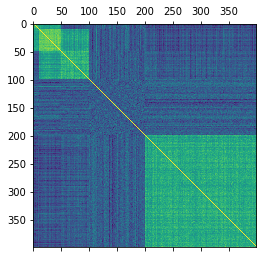

In [57]:
plt.matshow(np.cov(X, rowvar = False))

### PCA

With overlapping loading vectors and $p>n$ PCA is not able to recover the factor structure. 

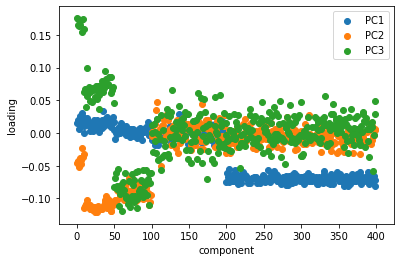

In [58]:
pca = PCA(n_components=3)
pca.fit(X)
loadings = pca.components_.T 

p,l = loadings.shape
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l], label = "PC" + str(l+1))
    
plt.xlabel("component")
plt.ylabel("loading")
plt.legend()

### Treelet decomposition

Using the treelet decomposition the factor structure is somewhat clearer. In particular, the fourth block is easily identifiable.

In [59]:
tree = pytree.treelet_decomposition(X = X, 
                                    L = 400)
best_K_bases = pytree.best_basis(tree,3,X)
loadings = best_K_bases[0]["basis"]
loadings

100%|██████████| 399/399 [01:55<00:00,  3.47it/s]


array([[ 0.04592926,  0.        , -0.0041755 ],
       [ 0.04505607,  0.        , -0.00409612],
       [ 0.04324979,  0.        , -0.00393191],
       ...,
       [ 0.00609555,  0.        ,  0.06703981],
       [ 0.00660621,  0.        ,  0.07265617],
       [ 0.00717863,  0.        ,  0.07895178]])

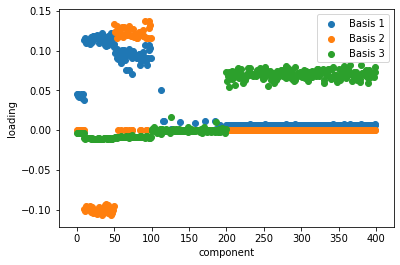

In [60]:
p,l = loadings.shape
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l], label = "Basis " + str(l+1))

plt.xlabel("component")
plt.ylabel("loading")
plt.legend()